## Super Res GANs

In [1]:
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from fastai.vision.gan import *

from torchvision.models import vgg16_bn

In [3]:
from PIL import Image, ImageDraw, ImageFont

In [4]:
class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

In [5]:
path = untar_data(URLs.PETS)

In [6]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/small-96'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/small-256'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations')]

In [7]:
path_hr = path/'images'
path_lr = path/'crappy'

In [ ]:
il = ImageList.from_folder(path_hr)

In [ ]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [8]:
il = ImageList.from_folder(path_hr)
parallel(crappifier(path_lr, path_hr), il.items)

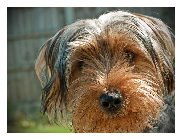

In [9]:
il[3].show()

## Time to train the GAN

In [10]:
bs, size = 32, 128
arch = models.resnet34

In [11]:
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [12]:
def return_data(bs, size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [13]:
data = return_data(bs, size)

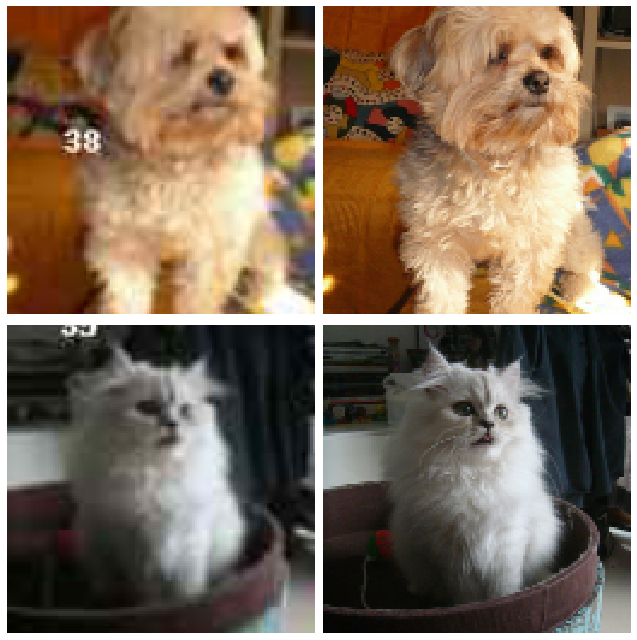

In [14]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

In [15]:
wd = 1e-3

In [16]:
y_range = (-3., 3.)

In [17]:
loss_fn = MSELossFlat()

In [18]:
def create_generator_learner():
    return unet_learner(data, arch, wd=wd, blur=True, norm_type=NormType.Weight, self_attention=True,
                       y_range=y_range, loss_func=loss_fn)

In [19]:
learn_gen = create_generator_learner()

In [20]:
learn_gen.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


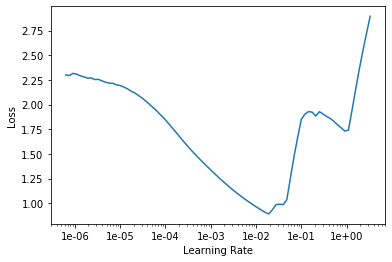

In [21]:
learn_gen.recorder.plot()

In [22]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.067682,0.053657,00:48
1,0.066063,0.059498,00:46


In [23]:
learn_gen.unfreeze()

In [25]:
learn_gen.fit_one_cycle(3, slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,time
0,0.053477,0.049724,00:50
1,0.050879,0.046857,00:50
2,0.048411,0.045748,00:50


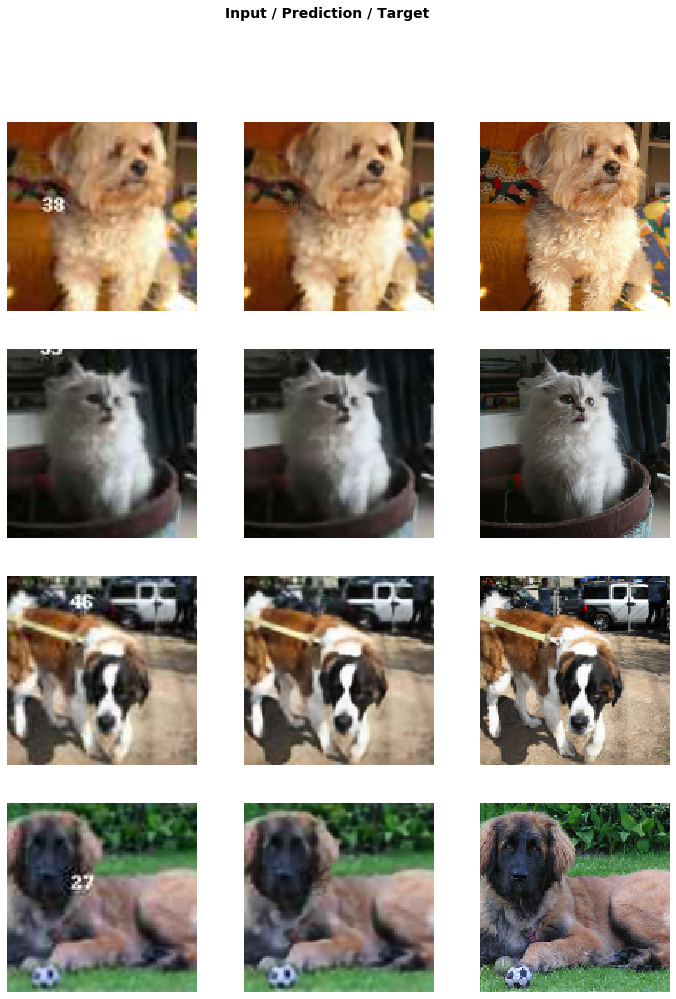

In [26]:
learn_gen.show_results(rows=4)

In [27]:
learn_gen.save('gen-pre2')

## Saving predicted images

In [33]:
learn_gen.load('gen-pre2');

In [29]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [30]:
# shutil.rmtree(path_gen)

In [31]:
path_gen.mkdir(exist_ok=True)

In [34]:
def save_preds(dl):
    i = 0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [35]:
save_preds(data.fix_dl)

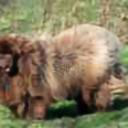

In [36]:
PIL.Image.open(path_gen.ls()[0])

## Critic Training

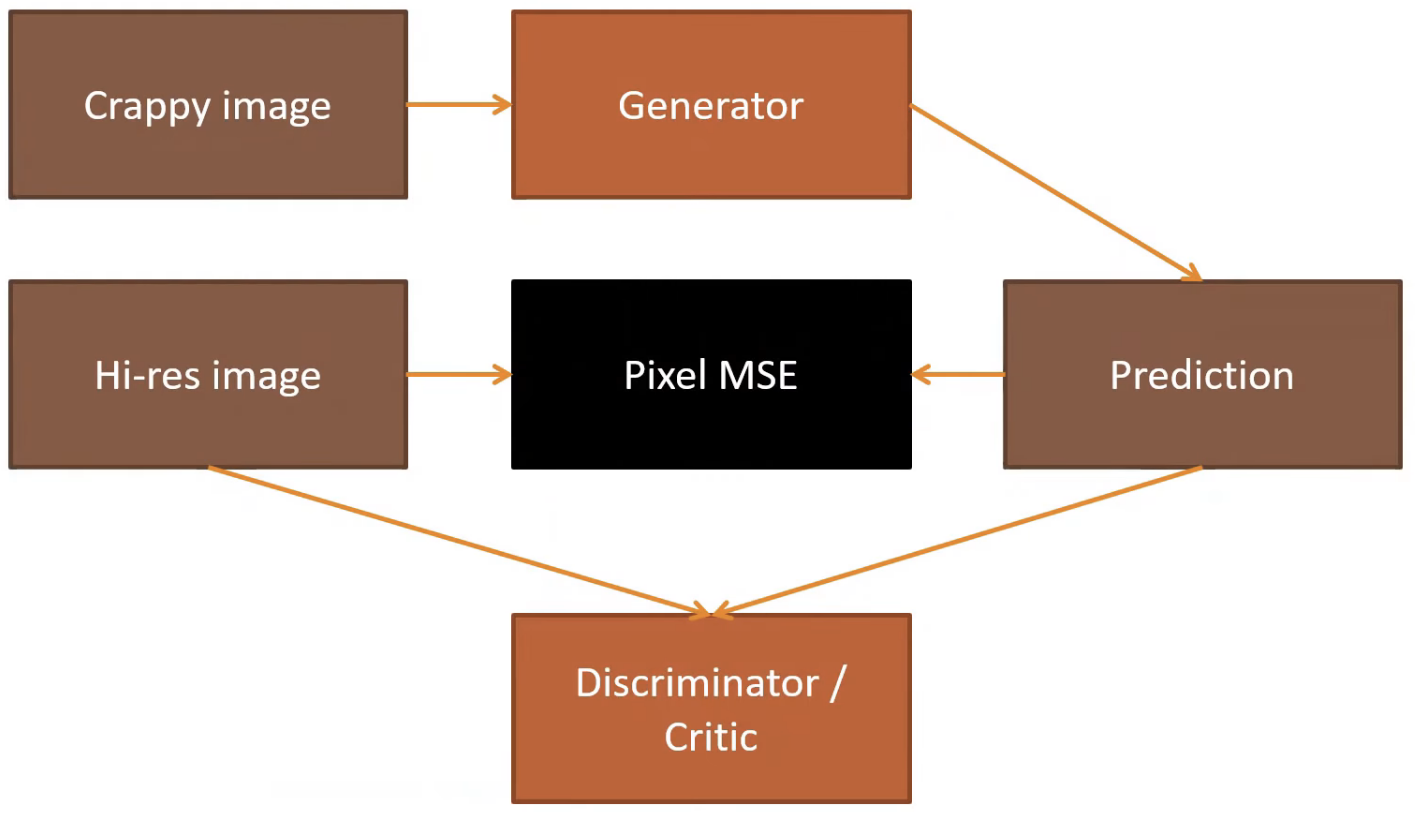

We could also train another model which we would variously call either the discriminator or the critic - they both mean the same thing. I'll call it a critic. We could try and build a binary classification model that takes all the pairs of the generated image and the real high-res image, and learn to classify which is which. So look at some picture and say "hey, what do you think? Is that a high-res cat or is that a generated cat? How about this one? Is that a high-res cat or a generated cat?" So just a regular standard binary cross-entropy classifier. We know how to do that already. If we had one of those, we could fine tune the generator and rather than using pixel MSE is the loss, the loss could be how good are we at fooling the critic? Can we create generated images that the critic thinks are real?

That would be a very good plan, because if it can do that, if the loss function is "am I fooling the critic?" then it's going to learn to create images which the critic can't tell whether they're real or fake. So we could do that for a while, train a few batches. But the critic isn't that great. The reason the critic isn't that great is because it wasn't that hard. These images are really crappy, so it's really easy to tell the difference. So after we train the generator a little bit more using that critic as the loss function, the generators going to get really good at falling the critic. So now we're going to stop training the generator, and we'll train the critic some more on these newly generated images. Now that the generator is better, it's now a tougher task for the critic to decide which is real and which is fake. So we'll train that a little bit more. Then once we've done that and the critic is now pretty good at recognizing the difference between the better generated images and the originals, we'll go back and we'll fine tune the generator some more using the better discriminator (i.e. the better critic) as the loss function.

In [37]:
learn_gen = None
gc.collect()

30073

Pretrain the critic on crappy vs not crappy.

In [45]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size).databunch(bs=bs).normalize(imagenet_stats))
    
    data.c = 3
    
    return data

In [46]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

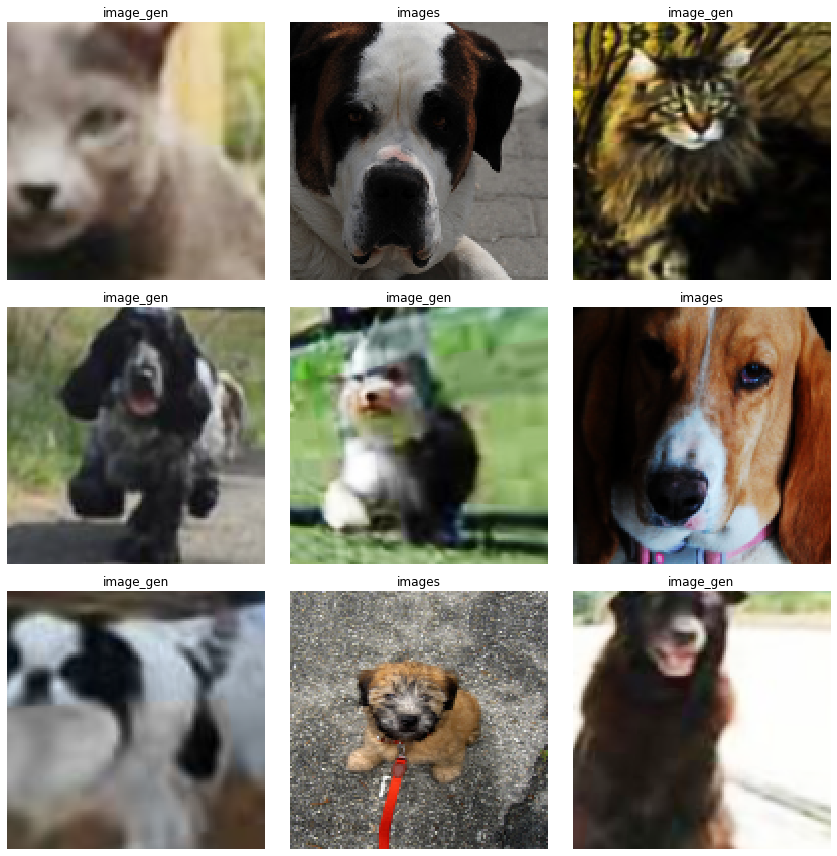

In [47]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, size=3)

In [48]:
loss_fn_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [51]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_fn_critic, wd=wd)

In [56]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [53]:
learn_critic.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


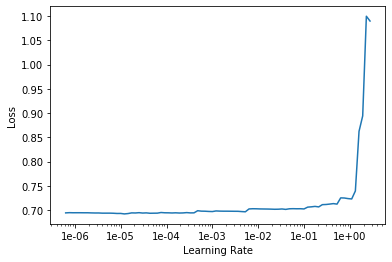

In [54]:
learn_critic.recorder.plot()

In [57]:
learn_critic.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.667997,0.689538,0.579516,01:48
1,0.368657,0.267358,0.892422,01:48
2,0.164954,0.102297,0.971738,01:48
3,0.081185,0.082500,0.969573,01:48
4,0.060818,0.052690,0.982165,01:48
5,0.038471,0.044259,0.986382,01:48


In [58]:
learn_critic.save('critic-pre2')